### Portfolio Analysis based on your Risk Aversion level and timeframe
We have 3 levels of Risk Aversion, with level 3 being the most aggressive
We have 3 timeframes for which we will do our Monte Carlo forecasts: 5, 10, and 20 years.

In [1]:
# Import the required libraries and dependencies
import os
import requests
import json
import pandas as pd
import sys
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
#chaim edit 11/3/21 
from utils.writeToCSV import writeToCSV #importing to write results to CSV file
from utils.get_dates import get_start_date
from utils.get_dates import get_end_date

from utils.function_eff_front import efficient_frontier #bipasha's import for her weight optimization

#from pathlib import Path
#import csv
%matplotlib inline

In [2]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

In [3]:
#User inputs 
while True:
    try:
        portfolio_value = input("To begin, please enter the amount to be invested (USD). If you would like to quit, please enter 'Quit': \n")
    
        if portfolio_value == 'Quit':
            print('You have quit the program. Have a nice day.')
            
            break
        
        portfolio_value = float(portfolio_value)
        
        if portfolio_value < 1000000:
            print("Unfortunately, you do not have enough savings to invest in a portfolio. \nThe minimum required is $1,000,000.")
            sys.exit("The application is now exiting.")
    
        break
    except ValueError:
        print("Please only enter numerical digits.")

To begin, please enter the amount to be invested (USD). If you would like to quit, please enter 'Quit': 
 5000000


In [4]:
#Get user input for risk tolerance. User must input 1, 2, or 3. If risk_tolerance is not one of these, we prompt user
#to try again.
risk_tolerance = input("Please select your risk tolerance level from 1-3, 3 being the most aggressive: ")
#print(risk_tolerance)
#type if statment here
if int(risk_tolerance) == 1:
    tickers = ["JPM","VTEB","PZA","BNDX","GOOGL"]
    #weights1 = sljflsdlkfj
    print("Thank you for your response!  You are a conversative investor.")
    print(f"The stocks in your portfolio will be {tickers}")
    #JP Morgan, Vanguard Tax-Exempt Bond Index Fund ETF, Invesco National AMT-Free Municipal Bond ETF, Vanguard Total International Bond Index Fund
    #Google
elif int(risk_tolerance) == 2:
    tickers = ["FB","AAPL","TSLA","HD","GS"]
    print("Thank you for your response!  You are an aggressive investor.")
    print(f"The stocks in your portfolio will be {tickers}")
    #Facebook, Apple, Tesla, Home Depot, Goldman Sachs
elif int(risk_tolerance) == 3:
    tickers = ["NFLX","ADBE","AMZN","PYPL","GME"]
    print("Thank you for your response!  You are a very aggressive investor.")
    print(f"The stocks in your portfolio will be {tickers}")
    #Netflix, Adobe, Amazon, Paypal, GameStop

else:
    print("I'm sorry, you need to enter 1, 2, or 3 for the application to work.")
#chaim edit- changed the print function to simplify output
risk_tolerance = int(risk_tolerance) #force it to be a number since the result of input() is a string



    

Please select your risk tolerance level from 1-3, 3 being the most aggressive:  1


Thank you for your response!  You are a conversative investor.
The stocks in your portfolio will be ['JPM', 'VTEB', 'PZA', 'BNDX', 'GOOGL']


In [5]:
# Set the variables for the Alpaca API and secret keys. Will be making calls for historical prices.
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")


str

str

In [6]:
# Set the tickers for both the bond and stock portion of the portfolio

#This setting of tickers will also need to be made a bit more dynamic again dep on what client selects
#We know this would be risk tolerance level 2 based on Nev's list.
#tickers = ["FB","AAPL","TSLA","RDS.A","GS"] Paul Lopez moved this up on 2021-10-29 to the top depending on if client enters 1, 2, or 3 for risk tolerance

# Set timeframe to 1D 
timeframe = "1D"

# Format current date as ISO format
# Set both the start and end date at the date of your prior business day 
# This will give you the closing price of the previous trading day
#Made it dynamic so start and end date are always T-1 business days 20211104
start_date = get_start_date() #pd.Timestamp("2021-10-27", tz="America/New_York").isoformat()
end_date = get_start_date() #pd.Timestamp("2021-10-27", tz="America/New_York").isoformat()
limit_rows = 1000
start_date

'2021-11-10T00:00:00-05:00'

In [7]:
# We use the Alpaca get_barset function to get current closing prices for our portfolio of 5 tickers
prices_df = alpaca.get_barset(tickers, timeframe, start=start_date, end=end_date, limit=limit_rows).df

# checking dataframe to make sure everything looks ok for our closes
prices_df.head()


BNDX                               GOOGL          \
                            open   high    low  close   volume  open    high   
time                                                                           
2021-11-10 00:00:00-05:00  57.23  57.22  56.97  56.97  2499917  2950  2961.4   

                                                      ...    PZA         \
                               low    close   volume  ...   open   high   
time                                                  ...                 
2021-11-10 00:00:00-05:00  2890.75  2918.79  1314990  ...  27.07  27.07   

                                                  VTEB                        \
                             low  close  volume   open   high    low   close   
time                                                                           
2021-11-10 00:00:00-05:00  26.99  26.99  280765  54.93  54.94  54.84  54.845   

                                    
                            volume  
time                                
2021-11-10 00:00:00-05:00  1066103  

[1 rows x 25 columns]

In [8]:
# Access the closing prices for our 5 tickers from the Alpaca DataFrame
# We also convert the value to a floating point number
#Again will need to be made dynamic depending on if level 1 2 or 3 risk tolerance level is selected
stock1_close_price = float(prices_df[tickers[0]]["close"])
stock2_close_price = float(prices_df[tickers[1]]["close"])
stock3_close_price = float(prices_df[tickers[2]]["close"])
stock4_close_price = float(prices_df[tickers[3]]["close"])
stock5_close_price = float(prices_df[tickers[4]]["close"])

display(stock1_close_price)
display(stock2_close_price)
display(stock3_close_price)
display(stock4_close_price)
display(stock5_close_price)

167.62

54.845

26.99

56.97

2918.79

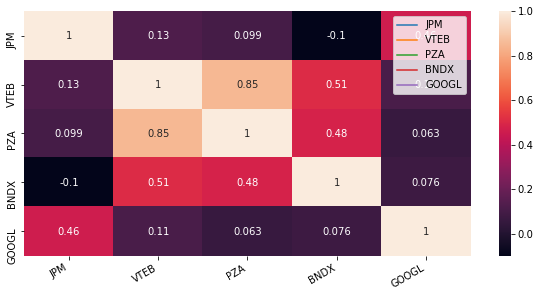

                 JPM      VTEB       PZA      BNDX     GOOGL
Date                                                        
2016-01-05  0.000006  0.000252  0.000843 -0.000214  0.000272
2016-01-06 -0.000052  0.000660  0.001402  0.001429 -0.000285
2016-01-07 -0.000145 -0.000094  0.000280 -0.000569 -0.002386
2016-01-08 -0.000080  0.000125  0.000000 -0.000071 -0.001346
2016-01-11 -0.000005 -0.000438 -0.000977 -0.000428  0.000292


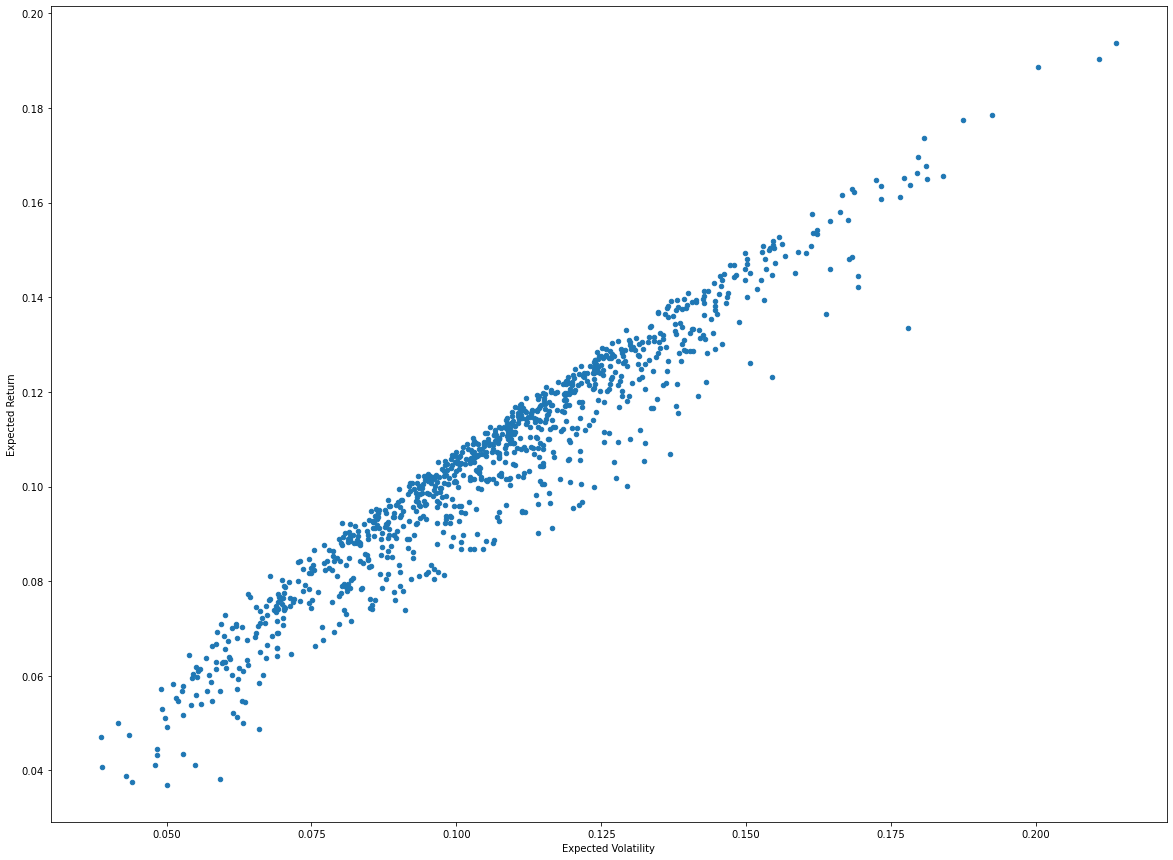

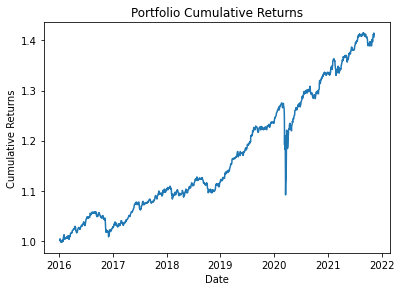

With $17935.47 you will be able to purchase 107 shares of JPM.
With $803252.38 you will be able to purchase 14646 shares of VTEB.
With $1792939.82 you will be able to purchase 66430 shares of PZA.
With $1891756.60 you will be able to purchase 33206 shares of BNDX.
With $494115.73 you will be able to purchase 169 shares of GOOGL.


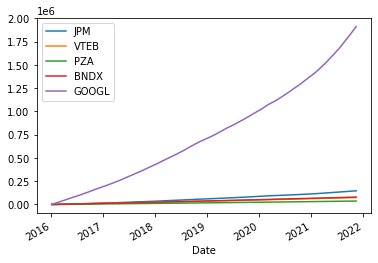

In [9]:
# Calculate the current value of the bond portion of the portfolio
#Again will need to be made dynamic depending on if level 1 2 or 3 risk tolerance level is selected
#value_per_share = portfolio_value/5 

weights_eff = efficient_frontier(tickers) #[num1, num2, num3, num4, num5]

weight1 = weights_eff[0]
weight2 = weights_eff[1]
weight3 = weights_eff[2]
weight4 = weights_eff[3]
weight5 = weights_eff[4]


#Paul Lopez added sample code for Bipasha to use when her dynamic weights- 20211103
value_share1 = portfolio_value * weight1 #weight1 will be the weight as determined by Bipasha's algorithm
value_share2 = portfolio_value * weight2
value_share3 = portfolio_value * weight3
value_share4 = portfolio_value * weight4
value_share5 = portfolio_value * weight5


stock1_shares = value_share1 / stock1_close_price
stock2_shares = value_share2 / stock2_close_price
stock3_shares = value_share3 / stock3_close_price
stock4_shares = value_share4 / stock4_close_price
stock5_shares = value_share5 / stock5_close_price

# Print how many shares we get of each stock assuming 200k is available for each one.
print(f"With ${value_share1:.2f} you will be able to purchase {stock1_shares:.0f} shares of {tickers[0]}.")
print(f"With ${value_share2:.2f} you will be able to purchase {stock2_shares:.0f} shares of {tickers[1]}.")
print(f"With ${value_share3:.2f} you will be able to purchase {stock3_shares:.0f} shares of {tickers[2]}.")
print(f"With ${value_share4:.2f} you will be able to purchase {stock4_shares:.0f} shares of {tickers[3]}.")
print(f"With ${value_share5:.2f} you will be able to purchase {stock5_shares:.0f} shares of {tickers[4]}.")


In [10]:
# Set start and end dates of 10 years back from your current date
#We'll always assume 10 years back. Again we can make this dynamic if we want
#and start with yesterday's date and then go back 10 years.
#Added dynamic start and end date 20211104 Paul Lopez
start_date = get_end_date() #pd.Timestamp("2011-10-28", tz="America/New_York").isoformat()
end_date = get_start_date() #pd.Timestamp("2021-10-28", tz="America/New_York").isoformat()

display(start_date)
display(end_date)
limit_rows = 1000

'2011-09-15T00:00:00-04:00'

'2021-11-10T00:00:00-05:00'

In [11]:
# Use the Alpaca get_barset function to make the API call to get the 3 years worth of pricing data
# The tickers and timeframe parameters should have been set in Part 1 of this activity 
# The start and end dates should be updated with the information set above
# Remember to add the df property to the end of the call so the response is returned as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=limit_rows
).df

# Display both the first and last five rows of the DataFrame
display(prices_df.head(2))
display(prices_df.tail(2))
tickers

BNDX                                     GOOGL  \
                            open     high    low  close    volume     open   
time                                                                         
2017-11-20 00:00:00-05:00  54.91  55.0100  54.91  55.00  598007.0      NaN   
2017-11-21 00:00:00-05:00  55.07  55.0807  54.88  55.03  660093.0  1040.04   

                                                               ...    PZA  \
                              high      low   close    volume  ...   open   
time                                                           ...          
2017-11-20 00:00:00-05:00      NaN      NaN     NaN       NaN  ...    NaN   
2017-11-21 00:00:00-05:00  1050.39  1039.14  1050.3  558425.0  ...  25.61   

                                                             VTEB         \
                              high    low  close    volume   open   high   
time                                                                       
2017-11-20 00:00:00-05:00      NaN    NaN    NaN       NaN  51.62  51.64   
2017-11-21 00:00:00-05:00  25.6168  25.56  25.57  208363.0  51.64  51.64   

                                                     
                             low    close    volume  
time                                                 
2017-11-20 00:00:00-05:00  51.57  51.6000  202292.0  
2017-11-21 00:00:00-05:00  51.56  51.5601  349579.0  

[2 rows x 25 columns]

BNDX                                    GOOGL  \
                            open   high    low  close     volume     open   
time                                                                        
2021-11-09 00:00:00-05:00  57.23  57.31  57.23  57.29  2184755.0  2984.66   
2021-11-10 00:00:00-05:00  57.23  57.22  56.97  56.97  2499917.0  2950.00   

                                                                  ...    PZA  \
                              high       low    close     volume  ...   open   
time                                                              ...          
2021-11-09 00:00:00-05:00  2996.69  2944.895  2977.81   823577.0  ...  27.01   
2021-11-10 00:00:00-05:00  2961.40  2890.750  2918.79  1314990.0  ...  27.07   

                                                           VTEB           \
                            high    low  close    volume   open     high   
time                                                                       
2021-11-09 00:00:00-05:00  27.05  27.01  27.04  417756.0  54.91  54.9399   
2021-11-10 00:00:00-05:00  27.07  26.99  26.99  280765.0  54.93  54.9400   

                                                     
                             low   close     volume  
time                                                 
2021-11-09 00:00:00-05:00  54.85  54.890  1532966.0  
2021-11-10 00:00:00-05:00  54.84  54.845  1066103.0  

[2 rows x 25 columns]

['JPM', 'VTEB', 'PZA', 'BNDX', 'GOOGL']

###Here we run a Monte Carlo simulation of 500 samples and the time frame could be 5, 10, or 20 years depending on the user's response. We always will assume equal 20% weight for each stock in the portfolio.

In [12]:
# Configure the Monte Carlo simulation to forecast cumulative returns based on the client's input.

#Changed 2021-11-02. We will run 3 scenarios of 5yr, 10yr, and 20yr.
# The weights we will assume will be split evenly 20 percent for each ticker.
# We will be running 1000 samples.
MC_even_weight_5yr = MCSimulation(
    portfolio_data = prices_df,
    weights = weights_eff,
    num_simulation = 500,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*5 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 5 now
)

# Review the simulation input data
MC_even_weight_5yr.portfolio_data.head()


C:\Users\niklo\OneDrive\desktop\FinTech-Workspace\Project_1_Bootcamp\MCForecastTools.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if weights == "":


BNDX                                     \
                            open     high    low   close     volume   
time                                                                  
2017-11-20 00:00:00-05:00  54.91  55.0100  54.91  55.000   598007.0   
2017-11-21 00:00:00-05:00  55.07  55.0807  54.88  55.030   660093.0   
2017-11-22 00:00:00-05:00  55.09  55.1300  55.07  55.115   557512.0   
2017-11-24 00:00:00-05:00  55.08  55.1000  55.05  55.070   277937.0   
2017-11-27 00:00:00-05:00  55.12  55.1300  55.07  55.120  1059044.0   

                                          GOOGL                             \
                          daily_return     open     high      low    close   
time                                                                         
2017-11-20 00:00:00-05:00          NaN      NaN      NaN      NaN      NaN   
2017-11-21 00:00:00-05:00     0.000545  1040.04  1050.39  1039.14  1050.30   
2017-11-22 00:00:00-05:00     0.001545  1051.11  1055.43  1047.25  1051.86   
2017-11-24 00:00:00-05:00    -0.000816  1054.39  1060.07  1051.92  1056.61   
2017-11-27 00:00:00-05:00     0.000908  1058.57  1073.04  1054.77  1072.05   

                           ...     PZA                                 VTEB  \
                           ...     low  close    volume daily_return   open   
time                       ...                                                
2017-11-20 00:00:00-05:00  ...     NaN    NaN       NaN          NaN  51.62   
2017-11-21 00:00:00-05:00  ...  25.560  25.57  208363.0          NaN  51.64   
2017-11-22 00:00:00-05:00  ...  25.510  25.54  212652.0    -0.001173  51.57   
2017-11-24 00:00:00-05:00  ...  25.480  25.52   95325.0    -0.000783  51.39   
2017-11-27 00:00:00-05:00  ...  25.466  25.47  178526.0    -0.001959  51.42   

                                                                           
                            high      low    close    volume daily_return  
time                                                                       
2017-11-20 00:00:00-05:00  51.64  51.5700  51.6000  202292.0          NaN  
2017-11-21 00:00:00-05:00  51.64  51.5600  51.5601  349579.0    -0.000773  
2017-11-22 00:00:00-05:00  51.57  51.4400  51.4900  361349.0    -0.001360  
2017-11-24 00:00:00-05:00  51.49  51.3807  51.4800  292029.0    -0.000194  
2017-11-27 00:00:00-05:00  51.47  51.3900  51.4100  348186.0    -0.001360  

[5 rows x 30 columns]

In [13]:
MC_even_weight_10yr = MCSimulation(
    portfolio_data = prices_df,
    weights = weights_eff,
    num_simulation = 500,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*10 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 10 now
)

MC_even_weight_10yr.portfolio_data.head()

C:\Users\niklo\OneDrive\desktop\FinTech-Workspace\Project_1_Bootcamp\MCForecastTools.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if weights == "":


BNDX                                     \
                            open     high    low   close     volume   
time                                                                  
2017-11-20 00:00:00-05:00  54.91  55.0100  54.91  55.000   598007.0   
2017-11-21 00:00:00-05:00  55.07  55.0807  54.88  55.030   660093.0   
2017-11-22 00:00:00-05:00  55.09  55.1300  55.07  55.115   557512.0   
2017-11-24 00:00:00-05:00  55.08  55.1000  55.05  55.070   277937.0   
2017-11-27 00:00:00-05:00  55.12  55.1300  55.07  55.120  1059044.0   

                                          GOOGL                             \
                          daily_return     open     high      low    close   
time                                                                         
2017-11-20 00:00:00-05:00          NaN      NaN      NaN      NaN      NaN   
2017-11-21 00:00:00-05:00     0.000545  1040.04  1050.39  1039.14  1050.30   
2017-11-22 00:00:00-05:00     0.001545  1051.11  1055.43  1047.25  1051.86   
2017-11-24 00:00:00-05:00    -0.000816  1054.39  1060.07  1051.92  1056.61   
2017-11-27 00:00:00-05:00     0.000908  1058.57  1073.04  1054.77  1072.05   

                           ...     PZA                                 VTEB  \
                           ...     low  close    volume daily_return   open   
time                       ...                                                
2017-11-20 00:00:00-05:00  ...     NaN    NaN       NaN          NaN  51.62   
2017-11-21 00:00:00-05:00  ...  25.560  25.57  208363.0          NaN  51.64   
2017-11-22 00:00:00-05:00  ...  25.510  25.54  212652.0    -0.001173  51.57   
2017-11-24 00:00:00-05:00  ...  25.480  25.52   95325.0    -0.000783  51.39   
2017-11-27 00:00:00-05:00  ...  25.466  25.47  178526.0    -0.001959  51.42   

                                                                           
                            high      low    close    volume daily_return  
time                                                                       
2017-11-20 00:00:00-05:00  51.64  51.5700  51.6000  202292.0          NaN  
2017-11-21 00:00:00-05:00  51.64  51.5600  51.5601  349579.0    -0.000773  
2017-11-22 00:00:00-05:00  51.57  51.4400  51.4900  361349.0    -0.001360  
2017-11-24 00:00:00-05:00  51.49  51.3807  51.4800  292029.0    -0.000194  
2017-11-27 00:00:00-05:00  51.47  51.3900  51.4100  348186.0    -0.001360  

[5 rows x 30 columns]

In [14]:
MC_even_weight_20yr = MCSimulation(
    portfolio_data = prices_df,
    weights = weights_eff,
    num_simulation = 500,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*20 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 20 now
)
MC_even_weight_20yr.portfolio_data.head()

C:\Users\niklo\OneDrive\desktop\FinTech-Workspace\Project_1_Bootcamp\MCForecastTools.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if weights == "":


BNDX                                     \
                            open     high    low   close     volume   
time                                                                  
2017-11-20 00:00:00-05:00  54.91  55.0100  54.91  55.000   598007.0   
2017-11-21 00:00:00-05:00  55.07  55.0807  54.88  55.030   660093.0   
2017-11-22 00:00:00-05:00  55.09  55.1300  55.07  55.115   557512.0   
2017-11-24 00:00:00-05:00  55.08  55.1000  55.05  55.070   277937.0   
2017-11-27 00:00:00-05:00  55.12  55.1300  55.07  55.120  1059044.0   

                                          GOOGL                             \
                          daily_return     open     high      low    close   
time                                                                         
2017-11-20 00:00:00-05:00          NaN      NaN      NaN      NaN      NaN   
2017-11-21 00:00:00-05:00     0.000545  1040.04  1050.39  1039.14  1050.30   
2017-11-22 00:00:00-05:00     0.001545  1051.11  1055.43  1047.25  1051.86   
2017-11-24 00:00:00-05:00    -0.000816  1054.39  1060.07  1051.92  1056.61   
2017-11-27 00:00:00-05:00     0.000908  1058.57  1073.04  1054.77  1072.05   

                           ...     PZA                                 VTEB  \
                           ...     low  close    volume daily_return   open   
time                       ...                                                
2017-11-20 00:00:00-05:00  ...     NaN    NaN       NaN          NaN  51.62   
2017-11-21 00:00:00-05:00  ...  25.560  25.57  208363.0          NaN  51.64   
2017-11-22 00:00:00-05:00  ...  25.510  25.54  212652.0    -0.001173  51.57   
2017-11-24 00:00:00-05:00  ...  25.480  25.52   95325.0    -0.000783  51.39   
2017-11-27 00:00:00-05:00  ...  25.466  25.47  178526.0    -0.001959  51.42   

                                                                           
                            high      low    close    volume daily_return  
time                                                                       
2017-11-20 00:00:00-05:00  51.64  51.5700  51.6000  202292.0          NaN  
2017-11-21 00:00:00-05:00  51.64  51.5600  51.5601  349579.0    -0.000773  
2017-11-22 00:00:00-05:00  51.57  51.4400  51.4900  361349.0    -0.001360  
2017-11-24 00:00:00-05:00  51.49  51.3807  51.4800  292029.0    -0.000194  
2017-11-27 00:00:00-05:00  51.47  51.3900  51.4100  348186.0    -0.001360  

[5 rows x 30 columns]

In [15]:
# Run the Monte Carlo simulation to forecast client specified number of years of cumulative returns
#Changed on 2021-11-02 by Paul Lopez. Will now be running 5yr, 10yr, and 20yr MC scenarios.
MC_even_weight_5yr.calc_cumulative_return()

#Tweaked monte carlo py file to spit out a message every 200 simulations.

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995956,1.003642,0.987529,1.013253,1.000622,0.994417,1.010418,1.008654,1.000013,0.995742,...,1.005198,1.010452,1.000402,0.999553,0.981718,0.999439,0.987052,1.002808,1.004648,0.993522
2,0.985728,1.001118,0.987806,1.018558,1.009038,0.999716,1.010841,1.007080,0.998307,0.997686,...,1.003472,1.030200,0.992032,0.987491,0.990377,1.014643,0.999871,1.012320,1.005441,0.989946
3,0.988956,0.992807,0.992473,1.013931,1.006664,1.013760,1.021905,0.994860,1.008238,0.989408,...,1.012251,1.016920,1.000303,0.984406,0.990940,1.021332,1.007716,0.998449,0.999513,1.004816
4,0.985072,0.976176,1.002019,1.009559,1.017824,1.009208,1.027584,0.997051,0.992845,1.006747,...,1.016562,1.021816,1.000447,0.997703,0.977292,1.020793,1.023110,1.001171,0.992279,0.990478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.351524,1.205645,2.292138,1.648336,3.664259,1.852014,1.447942,1.439995,1.506594,2.212049,...,1.960991,1.675699,1.105373,1.537050,2.073388,1.329581,1.644804,1.526687,1.400782,1.629775
1257,1.354042,1.201516,2.305198,1.634497,3.653264,1.868889,1.450982,1.436897,1.510008,2.229187,...,1.973956,1.671358,1.106733,1.538175,2.035307,1.324818,1.650778,1.532833,1.397906,1.629664
1258,1.362550,1.193023,2.295766,1.616674,3.644846,1.866872,1.441751,1.421852,1.512381,2.202281,...,1.964123,1.680869,1.106479,1.550919,2.054701,1.326654,1.639709,1.528591,1.417680,1.620697
1259,1.377008,1.195183,2.266157,1.617577,3.614567,1.868618,1.460697,1.423531,1.535190,2.194958,...,1.939947,1.667996,1.106909,1.519433,2.062975,1.313910,1.645021,1.528591,1.433115,1.622833


In [16]:
MC_even_weight_10yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.011213,1.002090,1.008404,0.999403,1.000261,1.007606,0.995517,1.014600,1.004463,0.991731,...,1.003970,1.008385,0.995131,1.015526,0.988582,1.004746,1.014231,0.996869,1.015645,0.989178
2,1.013584,1.008527,1.024410,0.996273,0.995952,1.015433,0.998561,1.012999,0.996207,1.002141,...,1.014920,1.010731,0.991765,1.015882,0.996177,0.992525,1.009828,1.004741,1.025019,0.975819
3,1.003942,1.020028,1.011067,1.013094,0.999169,1.016792,0.999467,0.997829,0.972605,1.004245,...,1.021602,1.020237,0.986419,1.029988,1.000334,0.999554,0.999096,1.005020,1.027778,0.969877
4,1.002625,1.027353,1.016744,1.024961,1.002747,1.026405,1.010706,0.992450,0.970047,1.007017,...,1.026650,1.009838,0.970235,1.031499,1.002583,0.987624,1.002807,0.989975,1.018457,0.966384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,4.939011,1.792242,5.348960,0.983766,4.700370,1.670632,4.585294,4.589110,1.509720,4.355550,...,4.788793,2.812720,3.084959,2.000727,3.975733,1.633858,3.659695,0.830408,4.820573,1.663828
2517,4.957881,1.787619,5.311552,0.988960,4.677076,1.668467,4.608482,4.546815,1.522148,4.363030,...,4.842986,2.863605,3.044870,2.002018,4.019375,1.635982,3.678722,0.826504,4.763054,1.651997
2518,5.006001,1.808112,5.401875,0.979230,4.745105,1.684601,4.569678,4.553039,1.520784,4.329723,...,4.873919,2.831220,3.023369,2.002807,4.021298,1.621382,3.671886,0.825815,4.723465,1.648303
2519,5.056685,1.801526,5.321903,0.991843,4.750077,1.691561,4.598941,4.581381,1.532313,4.279146,...,4.916547,2.810342,3.015864,2.005972,4.001818,1.592098,3.681954,0.817281,4.741656,1.650545


In [17]:
MC_even_weight_20yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.014699,0.987170,0.999955,1.002697,0.994381,1.007352,1.010801,0.991407,0.998247,0.994028,...,0.997249,0.999276,1.004341,0.990497,0.991745,1.003037,1.015179,1.003958,1.005617,0.997924
2,1.016644,0.972596,1.008044,0.998165,1.010657,1.003617,1.008233,0.982469,1.012839,1.000264,...,0.991949,0.991849,1.005059,0.991676,1.004034,1.009370,1.023151,1.008749,1.002932,0.993593
3,1.020681,0.982698,1.005456,0.999734,1.008339,0.995663,1.008056,0.993399,1.009148,1.016701,...,0.986272,0.984556,1.009787,0.979843,1.013256,1.004512,1.024710,1.023048,0.995959,1.004443
4,1.031317,0.970900,1.002275,1.000219,1.005765,1.004179,1.012061,0.988902,1.024162,1.018995,...,0.992744,0.971816,1.004781,0.988414,1.006582,1.007790,1.013636,1.026950,1.010059,1.011982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,7.880092,10.955701,10.197923,24.268685,5.665578,6.873213,5.774617,22.447754,9.071012,5.779749,...,3.732770,14.372422,10.123890,5.555828,10.081113,11.515069,7.696318,4.574548,9.388579,8.892728
5037,7.818667,11.150399,10.162889,24.332957,5.646510,6.890504,5.828907,22.171211,9.014202,5.816324,...,3.727372,14.315887,10.112167,5.522729,10.062141,11.555472,7.696891,4.496489,9.312573,8.942180
5038,7.756188,11.283725,10.070751,24.110389,5.693986,6.857884,5.869187,22.236758,9.091864,5.769027,...,3.704061,14.430318,10.130370,5.454101,10.206132,11.550592,7.521468,4.465413,9.319624,8.866244
5039,7.784955,11.360757,10.055531,23.839457,5.712779,6.909114,5.864766,22.624084,9.116400,5.804865,...,3.717110,14.426791,10.288664,5.505026,10.217032,11.462164,7.499396,4.414862,9.148936,8.856455


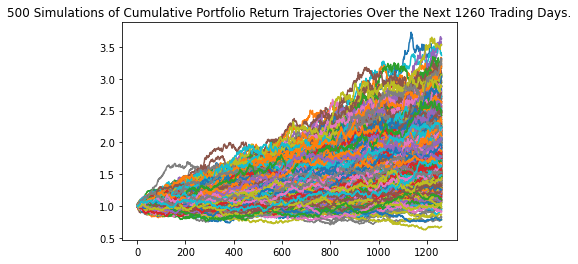

In [18]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 5yr scenario
MC_even_weight_line_5yr_plot = MC_even_weight_5yr.plot_simulation()


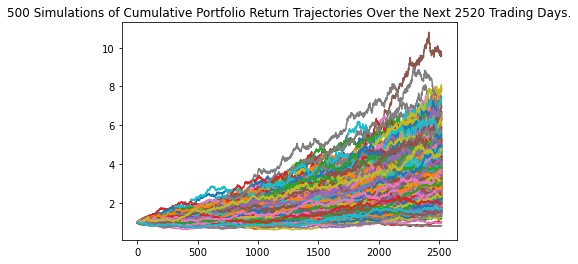

In [19]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 10yr scenario

MC_even_weight_line_10yr_plot = MC_even_weight_10yr.plot_simulation()

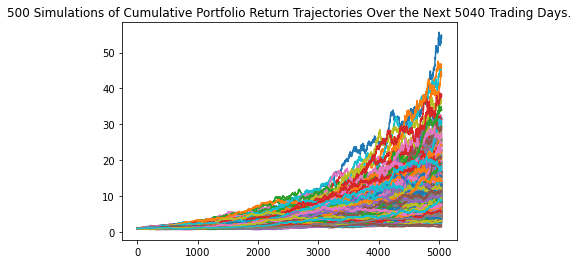

In [20]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 20yr scenario
MC_even_weight_line_20yr_plot = MC_even_weight_20yr.plot_simulation()

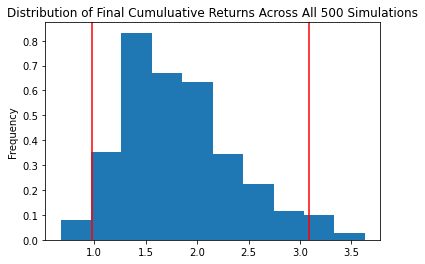

In [21]:
# Here we visualize the probability distribution of the Monte Carlo simulation 
# based on the user's timeframe by plotting a histogram
#Changed on 2021-11-02 by Paul Lopez. We are now plotting for all 3 time horizons of 5yr, 10yr, and 20yr.
MC_even_weight_5yr_distibution_plot = MC_even_weight_5yr.plot_distribution()

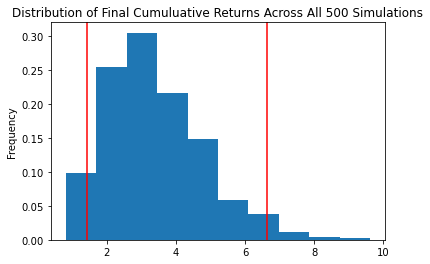

In [22]:
MC_even_weight_10yr_distibution_plot = MC_even_weight_10yr.plot_distribution()

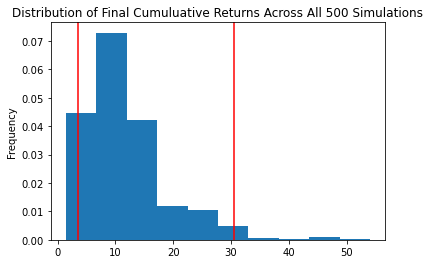

In [23]:
MC_even_weight_20yr_distibution_plot = MC_even_weight_20yr.plot_distribution()

#### Step 4: Generate the summary statistics for the Monte Carlo simulation.

In [24]:
# Generate summary statistics from the Monte Carlo simulation 5yr results
# We save the results as a variable
MC_even_weight_5yr_summary_table = MC_even_weight_5yr.summarize_cumulative_return()
# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_5yr_summary_table)

count           500.000000
mean              1.824551
std               0.543217
min               0.673660
25%               1.418562
50%               1.738140
75%               2.133499
max               3.630189
95% CI Lower      0.982124
95% CI Upper      3.082967
Name: 1260, dtype: float64


In [25]:
# Generate summary statistics from the Monte Carlo simulation 10yr results
# We save the results as a variable
MC_even_weight_10yr_summary_table = MC_even_weight_10yr.summarize_cumulative_return()
# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_10yr_summary_table)

count           500.000000
mean              3.409919
std               1.394360
min               0.817452
25%               2.381189
50%               3.187274
75%               4.249636
max               9.615944
95% CI Lower      1.424192
95% CI Upper      6.637789
Name: 2520, dtype: float64


In [26]:
# Generate summary statistics from the Monte Carlo simulation 20yr results
# We save the results as a variable
MC_even_weight_20yr_summary_table = MC_even_weight_20yr.summarize_cumulative_return()
# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_20yr_summary_table)

count           500.000000
mean             11.833186
std               7.295770
min               1.409007
25%               6.892293
50%              10.060040
75%              14.232956
max              54.061015
95% CI Lower      3.449347
95% CI Upper     30.479314
Name: 5040, dtype: float64


In [27]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_5yr = round(MC_even_weight_5yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_5yr = round(MC_even_weight_5yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 5 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_5yr} and ${ci_upper_thirty_cumulative_return_5yr}.")

There is a 95% chance that the current value of $5000000.00 in the portfolio with an even 20% weight in each stock over the next 5 years will end within the range of $4910622.25 and $15414836.09.


In [28]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_10yr = round(MC_even_weight_10yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_10yr = round(MC_even_weight_10yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 10 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_10yr} and ${ci_upper_thirty_cumulative_return_10yr}.")

There is a 95% chance that the current value of $5000000.00 in the portfolio with an even 20% weight in each stock over the next 10 years will end within the range of $7120960.93 and $33188946.15.


In [29]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_20yr = round(MC_even_weight_20yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_20yr = round(MC_even_weight_20yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 20 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_20yr} and ${ci_upper_thirty_cumulative_return_20yr}.")

There is a 95% chance that the current value of $5000000.00 in the portfolio with an even 20% weight in each stock over the next 20 years will end within the range of $17246737.4 and $152396571.4.


In [30]:
#created dictionary to store values for csv file
#client_info_dict = {
    #"Value of Portfolio" : [f"${portfolio_value:.2f}","-","-","-","-"],
    #"Value Per Share" : [f"${value_per_share:.2f}", f"${value_per_share:.2f}", f"${value_per_share:.2f}",
     #                    f"${value_per_share:.2f}", f"${value_per_share:.2f}"],
    #"Portfolio Tickers" : [tickers[0], tickers[1], tickers[2], tickers[3], tickers[4]],
    #"Shares per Ticker" : [f"{stock1_shares:.0f}", f"{stock2_shares:.0f}",f"{stock3_shares:.0f}", f"{stock4_shares:.0f}", f"{stock5_shares:.0f}"]    }  
#print(client_info_dict)

In [31]:
#created dataframe from dictionary
#client_info_df = pd.DataFrame(client_info_dict)
#client_info_df.set_index("Value of Portfolio")

In [32]:
#created csv with dataframe
#client_info_df.to_csv("Client Info.csv", index=False) #moved to util folder function 20211103 Paul Lopez

In [33]:
#created dictionary to turn into a csv file
#report_details_dict = {
 #   "Holding Period" : ["5year", "10year", "20year"],
  #  "Lower Bound Values" : [f"${ci_lower_thirty_cumulative_return_5yr}",f"${ci_lower_thirty_cumulative_return_10yr}",
   #                f"${ci_lower_thirty_cumulative_return_20yr}"],
    #"Upper Bound Values" : [f"${ci_upper_thirty_cumulative_return_5yr}",f"${ci_upper_thirty_cumulative_return_10yr}",
     #              F"${ci_upper_thirty_cumulative_return_20yr}"]}

In [34]:
#created dataframe with dictionary
#report_details_df = pd.DataFrame(report_details_dict)
#report_details_df.set_index("Holding Period")

In [35]:
# created csv file with dataframe
#report_details_df.to_csv("Report Details.csv", index=False) #moved to util folder function 20211103 Paul Lopez

In [36]:
#joining the dataframes together for the final report.
#joined_dataframes = pd.concat([client_info_df, report_details_df], axis=1)
#reviewing the joined dataframes to check for NAN's.
#joined_dataframes

In [37]:
#replacing NAN's with "-" to make the dataframe more user friendly.
#joined_dataframes = joined_dataframes.fillna("-")
#reviewing joined dataframes to check if the NAN's were replaced.
#joined_dataframes

In [38]:
#created dictionary for final report. updated by chaim 20211104
final_report_dict = {
    "Value of Portfolio" : [f"${portfolio_value:.2f}","-","-","-","-", "Holding Period", "5Year", "10Year", "20Year"],
    "Value Per Share" : [f"${value_share1:.2f}", f"${value_share2:.2f}", f"${value_share3:.2f}",
                         f"${value_share4:.2f}", f"${value_share5:.2f}", "Lower Bound Values",  
                         f"${ci_lower_thirty_cumulative_return_5yr}",f"${ci_lower_thirty_cumulative_return_10yr}",
                         f"${ci_lower_thirty_cumulative_return_20yr}"], 
    "Portfolio Tickers" : [tickers[0], tickers[1], tickers[2], tickers[3], tickers[4], "Upper Bound Values", 
                           f"${ci_upper_thirty_cumulative_return_5yr}",
                           f"${ci_upper_thirty_cumulative_return_10yr}",
                           f"${ci_upper_thirty_cumulative_return_20yr}"],
    "Shares per Ticker" : [f"{stock1_shares:.0f}", f"{stock2_shares:.0f}",f"{stock3_shares:.0f}",
                           f"{stock4_shares:.0f}", f"{stock5_shares:.0f}","-","-","-","-"]}
                           

In [39]:
#created a dataframe from the dictionary.
final_report_df = pd.DataFrame(final_report_dict)
final_report_df

,Value of Portfolio,Value Per Share,Portfolio Tickers,Shares per Ticker
0,$5000000.00,$17935.47,JPM,107
1,-,$803252.38,VTEB,14646
2,-,$1792939.82,PZA,66430
3,-,$1891756.60,BNDX,33206
4,-,$494115.73,GOOGL,169
5,Holding Period,Lower Bound Values,Upper Bound Values,-
6,5Year,$4910622.25,$15414836.09,-
7,10Year,$7120960.93,$33188946.15,-
8,20Year,$17246737.4,$152396571.4,-


In [40]:
#wrote the dataframe to a csv file to present for final report.
#writeToCSV("Client_Info.csv", "Report_Details.csv",client_info_df, report_details_df)
writeToCSV("FinalReport.csv", final_report_df) #updated by Chaim 20211104

Reports have been saved. Have a nice day!


In [41]:
#Adding Pie Chart of weights for each ticker in the portfolio
weights_df =  pd.DataFrame({"weight": weights_eff}, index=[tickers[0], tickers[1],tickers[2],tickers[3],tickers[4]])
# Display the weights_df DataFrame
weights_df

,weight
JPM,0.003587
VTEB,0.160650
PZA,0.358588
BNDX,0.378351
GOOGL,0.098823


<AxesSubplot:title={'center':'Portfolio Composition'}, ylabel='weight'>

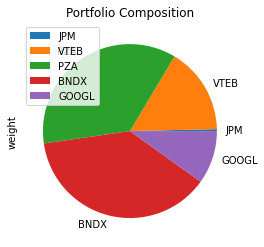

In [42]:
weights_df.plot.pie(y='weight' , title='Portfolio Composition')